# Package

In [20]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

#For data preprocessing
import numpy as np
import pandas as pd
import itertools
from sklearn.preprocessing import StandardScaler
import os
import random
import csv
import gc

#For plotting
import matplotlib.pyplot as plt

#For reproducibility
myseed = 42069  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Data Preprocessing

In [21]:
class DataPreprocessor:
    def __init__(self, preprocess_params):
        self.train_valid_ratio = preprocess_params["train_valid_ratio"]
        self.p_value_threshold = preprocess_params["p_value_threshold"]
        self.scaler = None

    def preproces_train_data(self, data_path):
        """
        get_lag_variable -> correlation coefficient -> split_train_valid -> normalize
        """
        data = pd.read_csv(data_path)
        X = data.loc[:, data.columns != "PM2.5"]
        y = data.loc[:, data.columns == "PM2.5"]
        #X = self.get_lag_variable(X, self.num_lag, isTesting = False)
        #X = X.dropna()
        X = self.do_correlation_coefficient_test(X, y, self.p_value_threshold)
        X_train, X_valid, y_train, y_valid = self.split_train_valid(X, y, self.train_valid_ratio)
        X_train = self.normalize(X_train, isTraining=True)
        X_valid = self.normalize(X_valid, isTraining=False)
        return X_train, X_valid, np.array(y_train), np.array(y_valid)

    def preprocess_test_data(self, data_path):
        """
        get_lag_variable -> correlation coefficient -> normalize
        """
        X_test = pd.read_csv(data_path)
        #X_test = self.get_lag_variable(X_test, self.num_lag, isTesting = True)
        X_test = X_test[self.kept_columns]
        X_test = self.normalize(X_test, isTraining=False)
        return X_test

    def normalize(self, data, isTraining = False):
        if isTraining:
            self.scaler = StandardScaler().fit(data)
        data_scaled = self.scaler.transform(data)
        return data_scaled

    def do_correlation_coefficient_test(self, X, y, p_value_threshold):
        corr_features = abs(X.corrwith(y['PM2.5'])).sort_values(ascending=False)
        print(corr_features)
        self.kept_columns = (corr_features[corr_features > p_value_threshold]).index
        X = X[self.kept_columns]
        return X

    def split_train_valid(self, X, y, train_valid_ratio = 0.75):
        data_len = len(X)
        train_len = round(train_valid_ratio * data_len)
        train_index = random.sample(range(data_len), train_len)
        valid_index = [i for i in range(data_len) if i not in train_index]
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index, :]
        X_valid = X.iloc[valid_index, :]
        y_valid = y.iloc[valid_index, :]
        return X_train, X_valid, y_train, y_valid

    # def get_lag_variable(self, data: pd.DataFrame, num_lag: int, isTesting = False):
    #     #start from 0
    #     data_ = data.copy()
    #     for idx in range(num_lag):
    #         #start from 1
    #         time = idx + 1
    #         lag_data = data.shift(time)
    #         lag_data.columns = [col + "_" + str(-time) for col in data.columns]
    #         data_ = pd.concat([data_, lag_data], axis = 1)
    #     #fill testing set nan with "mean" 
    #     if isTesting:
    #         data_.fillna(data_.mean(), inplace = True)
    #     return data_

In [29]:
data_path = "./data/"
train_path = os.path.join(data_path, "training_data.csv")
test_path = os.path.join(data_path, "testing_data.csv")
preprocess_params = {
    "train_valid_ratio": 0.75,
    "p_value_threshold": 0.3
}

DP = DataPreprocessor(preprocess_params)
X_train, X_valid, y_train, y_valid = DP.preproces_train_data(train_path)
X_test = DP.preprocess_test_data(test_path)

PM10        0.854973
CO          0.593970
CH4         0.526962
NO2         0.460302
NOx         0.391366
SO2         0.325951
AMB_TEMP    0.299272
NMHC        0.129990
NO          0.108846
RH          0.073292
dtype: float64


In [30]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(6588, 6)
(2196, 6)
(8760, 6)


In [31]:
class EPADataSet(Dataset):
    """Dataset for loading and preprocessing the EPA Weather data
    """
    def __init__(self, X, y = None, mode = "train"):
        self.mode = mode
        if mode in ["train", "valid"]:
            self.data = torch.from_numpy(X).float()
            self.target = torch.from_numpy(y.reshape(-1, 1)).float()
            self.dim = X.shape[1]
            # print(f"Check nan...")
            # if not np.any(np.isnan(X)) and not np.any(np.isnan(y)):
            #     print("No nan in dataset.")
        else:
            self.data = torch.from_numpy(X).float()
            self.dim = X.shape[1]
        #     print(f"Check nan...")
        #     if not np.any(np.isnan(X)):
        #         print("No nan in dataset.")

        print(f"Finish reading {self.mode} dataset ({len(self.data)} samples, {self.dim} features)")
        # if mode in ["train", "valid"]:
        #     print(f"Check target size... The target size is {len(self.target)}")
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode in ["train", "valid"]:
            return self.data[index], self.target[index]
        else:
            return self.data[index]

In [32]:
def prep_dataloader(mode, batch_size, X, y = None):
    """Generates a dataset, then is put into a dataloader. 
    """
    dataset = EPADataSet(X, y, mode)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle = (mode == "train"), drop_last=False, pin_memory = True)
    return dataloader

# Modeling

In [47]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
def plot_curve(train_loss, valid_loss):
    num_epoch = len(train_loss)
    x = [i+1 for i in range(num_epoch)]
    plt.plot(x, train_loss)
    plt.plot(x, valid_loss)
    plt.legend(["Training loss", "Validation loss"])
    plt.show()

In [54]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            #input layer
            nn.Linear(input_dim, 3), 
            nn.ReLU(),
            
            #hidden layer
            nn.Linear(3, 3),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(3, 3),
            nn.ReLU(),
            nn.Dropout(),

            #output layer
            nn.Linear(3, 1)
        )

        self.net.apply(self.init_weights)
        self.criterion = nn.MSELoss(reduction='mean')

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

In [36]:
def train(model, train_set, valid_set, params_set, device, verbose = False):
    #params settings
    num_epoch = params_set["num_epoch"]
    optimizer = getattr(torch.optim, params_set['optimizer'])(
    model.parameters(), **params_set['optim_hparams'])
    patience = params_set["patience"]

    #recording
    best_train_MSE = 0
    best_valid_MSE = 99999
    best_epoch = 0
    loss_record = {"train": [], "valid": []}

    #start training
    for idx_epoch in range(num_epoch):
        model.train()
        train_SSE = 0
        for idx, train_data in enumerate(train_set):
            X, y = train_data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_pred = model(X)
            train_loss = model.cal_loss(train_pred.flatten(), y.flatten())
            train_loss.backward()
            optimizer.step()
            train_SSE += (train_loss.detach().cpu().item()) * len(X)
        train_MSE = train_SSE / len(train_set.dataset)
        loss_record["train"].append(train_MSE)
        #validation
        valid_MSE = valid(model, valid_set, device)
        loss_record["valid"].append(valid_MSE)

        if verbose:
            print(f"Epoch {idx_epoch}, Train loss: {round(train_MSE, 4)}, Valid loss: {round(valid_MSE, 4)}")

        #save best result
        if valid_MSE < best_valid_MSE:
            best_valid_MSE = valid_MSE
            best_train_MSE = train_MSE
            best_epoch = idx_epoch
        
        #early stopping
        if valid_MSE > best_valid_MSE and idx_epoch >= best_epoch + patience:
            print("="*50)
            print("Early Stopping!")
            print(f"Best epoch is {best_epoch}, training loss = {round(best_train_MSE, 4)}, minimum valid loss = {round(best_valid_MSE, 4)}")
            return loss_record, model

    #Training until the final epoch
    print("=" * 50)
    print("Model result:")
    print(f"Best epoch is {best_epoch}, training loss = {round(best_train_MSE, 4)}, minimum valid loss = {round(best_valid_MSE, 4)}")
    return loss_record, model

def valid(model, valid_set, device):
    valid_SSE = 0
    with torch.no_grad():
        model.eval()     
        for idx, valid_data in enumerate(valid_set):
            X, y = valid_data
            X, y = X.to(device), y.to(device)
            valid_pred = model(X)
            valid_loss = model.cal_loss(valid_pred, y)
            valid_SSE += (valid_loss.detach().cpu().item()) * len(X)
    valid_MSE = valid_SSE / len(valid_set.dataset)
    return valid_MSE

def test(model, test_set, device):
    preds = []
    with torch.no_grad():
        model.eval()
        for X in test_set:
            X = X.to(device)
            test_pred = model(X)
            preds.append(test_pred.flatten().detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
    return preds

In [50]:
data_path = "./data/"
train_path = os.path.join(data_path, "training_data.csv")
test_path = os.path.join(data_path, "testing_data.csv")

In [51]:
preprocess_params = {
    "train_valid_ratio": 0.75,
    "p_value_threshold": 0.3
}

In [52]:
params_set = {
    "num_batch": [256, 512, 1024], 
    "num_epoch": [20, 50],
    #optimizer
    "optimizer": ["Adam"],
    "optim_hparams": [{
        "lr": [0.01, 0.05, 0.1, 0.5],
        "weight_decay": [0.01, 0.05, 0.1, 1, 10]
    }],
    #for early stopping
    "patience": [10]
}

param_grid = []
count = 0
for values in itertools.product(*params_set.values()):
    param = dict(zip(params_set.keys(), values))
    for optim_values in itertools.product(*param["optim_hparams"].values()):
        param_copy = param.copy()
        param_copy["optim_hparams"] = dict(zip(param["optim_hparams"].keys(), optim_values))
        param_grid.append(param_copy)

device = get_device() 
os.makedirs('models', exist_ok=True)

In [55]:
best_valid_loss = 10 ** 7
best_train_loss = 0
best_loss_record = None
best_model = None
best_params = None
count = 0
all_loss_record = list()

#change when you need to tune this model
model_save_path = "models/HW1.model_1101_1244.pth"

for param in param_grid:
        print("Parameter settings:")
        print(param)

        train_set = prep_dataloader("train", param["num_batch"], X_train, y_train)
        valid_set = prep_dataloader("valid", param["num_batch"], X_valid, y_valid)
        test_set = prep_dataloader("test", param["num_batch"], X_test)

        model = NeuralNet(train_set.dataset.dim).to(device)  # Construct model and move to device
        loss_record, local_best_model = train(model, train_set, valid_set, param, device, verbose = False)
        all_loss_record.append(min(loss_record["valid"]))
        if min(loss_record["valid"]) < best_valid_loss:
            best_valid_loss = min(loss_record["valid"])
            best_train_loss = min(loss_record["train"])
            best_loss_record = loss_record
            best_model = local_best_model
            best_params = param
            torch.save(best_model.state_dict(), model_save_path)
        print("="*50)
        count += 1

Parameter settings:
{'num_batch': 256, 'num_epoch': 20, 'optimizer': 'Adam', 'optim_hparams': {'lr': 0.01, 'weight_decay': 0.01}, 'patience': 10}
Finish reading train dataset (6588 samples, 6 features)
Finish reading valid dataset (2196 samples, 6 features)
Finish reading test dataset (8760 samples, 6 features)
Model result:
Best epoch is 17, training loss = 934.8623, minimum valid loss = 481.3353
Parameter settings:
{'num_batch': 256, 'num_epoch': 20, 'optimizer': 'Adam', 'optim_hparams': {'lr': 0.01, 'weight_decay': 0.05}, 'patience': 10}
Finish reading train dataset (6588 samples, 6 features)
Finish reading valid dataset (2196 samples, 6 features)
Finish reading test dataset (8760 samples, 6 features)
Model result:
Best epoch is 19, training loss = 928.5179, minimum valid loss = 510.24
Parameter settings:
{'num_batch': 256, 'num_epoch': 20, 'optimizer': 'Adam', 'optim_hparams': {'lr': 0.01, 'weight_decay': 0.1}, 'patience': 10}
Finish reading train dataset (6588 samples, 6 features)

In [56]:
print("="*10, "Tuning Result", "="*10)
print(f"Best params are: {best_params}")
print(f"Training MSE: {best_train_loss}, Valid MSE: {best_valid_loss}")

========== Tuning Result ==========
Best params are: {'num_batch': 512, 'num_epoch': 50, 'optimizer': 'Adam', 'optim_hparams': {'lr': 0.5, 'weight_decay': 1}, 'patience': 10}
Training MSE: 597.0316609774637, Valid MSE: 239.09855059847806


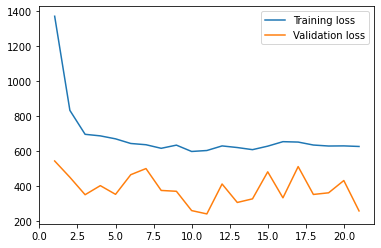

In [57]:
plot_curve(best_loss_record["train"], best_loss_record["valid"])

# Testing

In [58]:
y_pred = test(best_model, test_set, device)

In [59]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['INDEX', 'PM2.5'])
        for i, p in enumerate(preds):
            writer.writerow([i+1, p])

In [60]:
submit_path = "./submission/submission_1101_7.csv"
save_pred(y_pred, submit_path)

Saving results to ./submission/submission_1101_7.csv


# EDA

In [ ]:
for col in data_train.columns:
    plt.plot(data_train[col])
    plt.plot(data_train["PM2.5"])
    plt.legend([col, "PM2.5"])
    plt.title(col)
    plt.show()

NameError: name 'data_train' is not defined

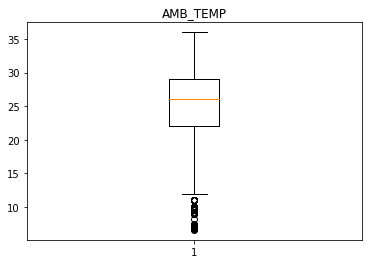

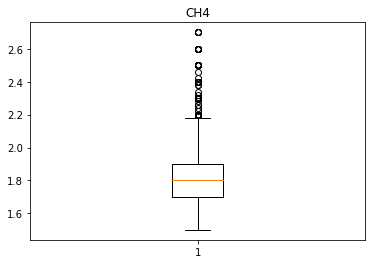

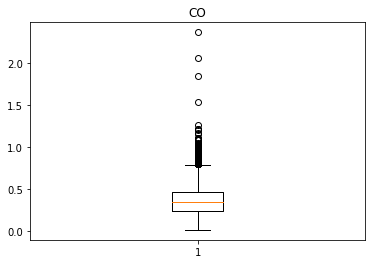

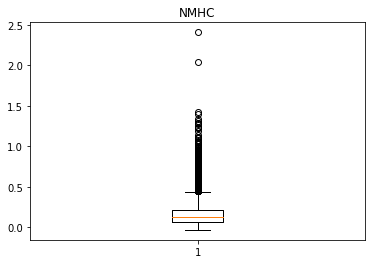

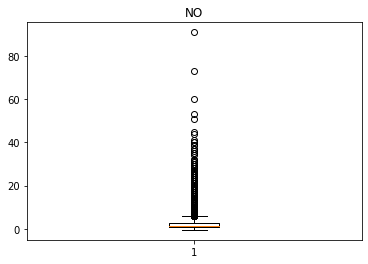

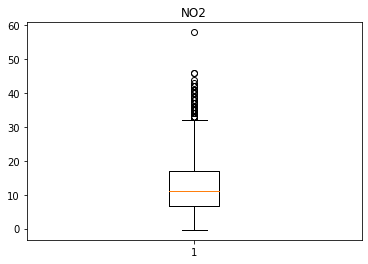

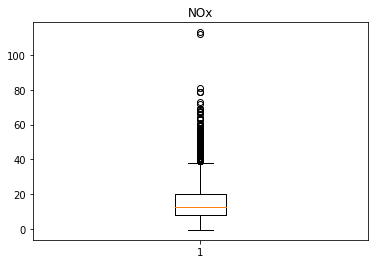

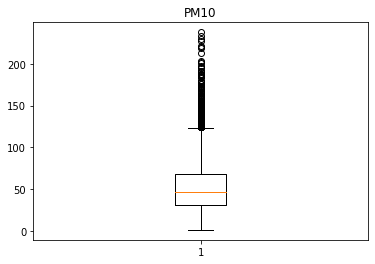

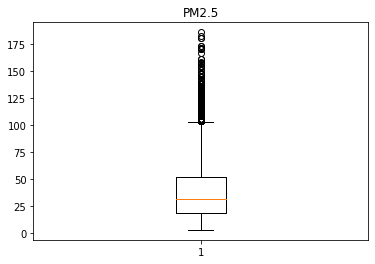

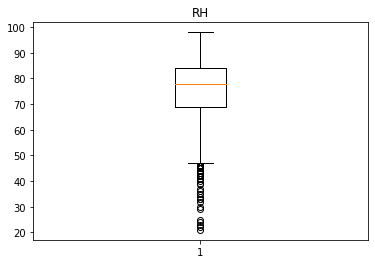

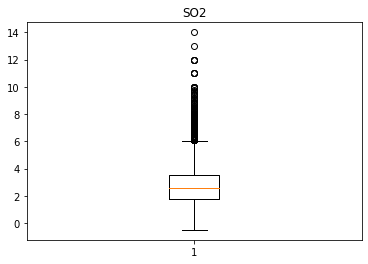

In [ ]:
for col in data_train.columns:
    plt.boxplot(data_train[col])
    plt.title(col)
    plt.show()

In [ ]:
data_test

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,PM10,RH,SO2
0,19.0,2.1,0.40,0.19,1.8,20.0,22.0,57.0,91.0,2.1
1,18.0,2.2,0.46,0.18,3.9,19.0,23.0,65.0,92.0,2.6
2,18.0,2.3,0.46,0.17,5.3,19.0,25.0,61.0,92.0,2.6
3,18.0,2.3,0.46,0.19,14.0,22.0,37.0,58.0,93.0,2.5
4,18.0,2.2,0.37,0.16,4.1,17.0,21.0,41.0,93.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8755,17.0,2.2,0.85,0.17,0.9,16.0,17.0,177.0,69.0,2.7
8756,17.0,2.2,0.82,0.17,0.9,18.0,18.0,143.0,70.0,2.3
8757,17.0,2.1,0.78,0.16,1.1,15.0,17.0,110.0,72.0,2.3
8758,16.0,2.1,0.73,0.14,1.2,17.0,18.0,96.0,73.0,2.4


# Deprecated

In [ ]:
model = NeuralNet(train_set.dataset.dim).to(device)
model_check_point = torch.load(model_save_path, map_location='cpu')
model.load_state_dict(model_check_point)

<All keys matched successfully>